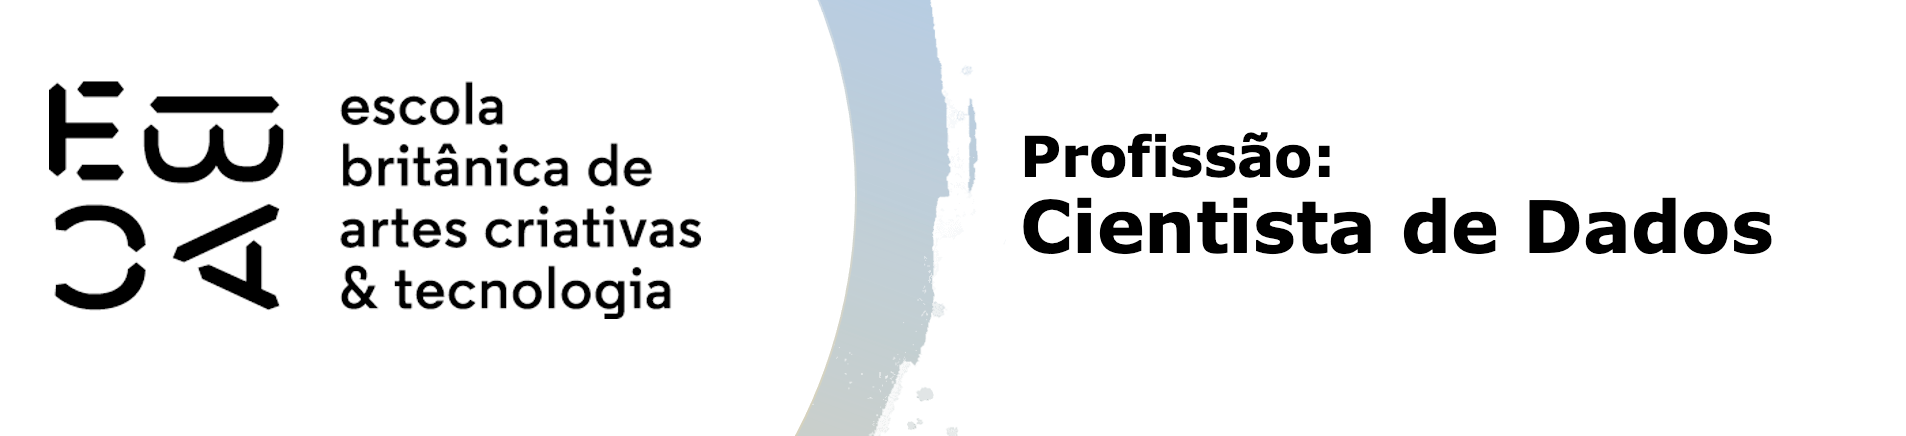

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy

import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

# Carregando o conjunto de dados
df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [2]:
# Preenchendo valores ausentes na coluna 'tempo_emprego' com a média
df.tempo_emprego.fillna(df.tempo_emprego.mean(), inplace=True)

In [3]:
# Aplicando a transformação logarítmica à coluna 'renda'
df['log_renda'] = np.log(df['renda'])

# Criando conjuntos de treinamento e teste
df_train = df[df['data_ref'] <= '2015-12-01'].copy()
df_test = df[df['data_ref'] > '2015-12-01'].copy()

In [4]:
# Definindo as variáveis para o melhor modelo
X1 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego 
                    + 1''', df_train)

# Ajustando o melhor modelo de regressão
res = smf.ols(X1, data=df_train).fit()

# Imprimindo o R-quadrado do modelo
print(f'Calculando o R-quadrado do modelo: {res.rsquared:.2%}')

Calculando o R-quadrado do modelo: 42.39%


In [5]:
# Aplicando a técnica LOWESS para suavizar a relação entre log_renda e tempo_emprego
lowess = sm.nonparametric.lowess(df_train.log_renda, df_train.tempo_emprego, frac=2/3)
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

# Executando a interpolação usando scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

# Criando uma nova coluna com os valores suavizados de tempo_emprego
df_train['tempo_emprego_lowess'] = f(df_train.tempo_emprego)
df_train.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda,idade_tempo_emprego,tempo_emprego_lowess
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131,785.736986,10.526933
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,7.793508,288.000000,9.495954
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,9.528769,229.830137,9.290507
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,7.767196,57.260274,8.484386
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,6.673020,41.408219,8.478176


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

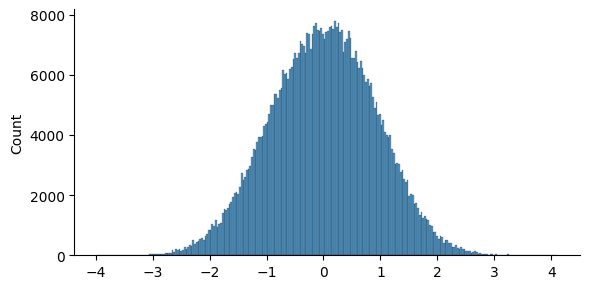

In [6]:
# Resíduos do modelo
residuos = res.resid

# Adicionando os resíduos ao DataFrame de treinamento
df_train['residuos'] = residuos

# Histograma dos resíduos
sns.displot(res.resid, height=3, aspect=2);

<span style="color:darkolivegreen;"> Os resíduos aparentam ter uma distribuição normal.</span>

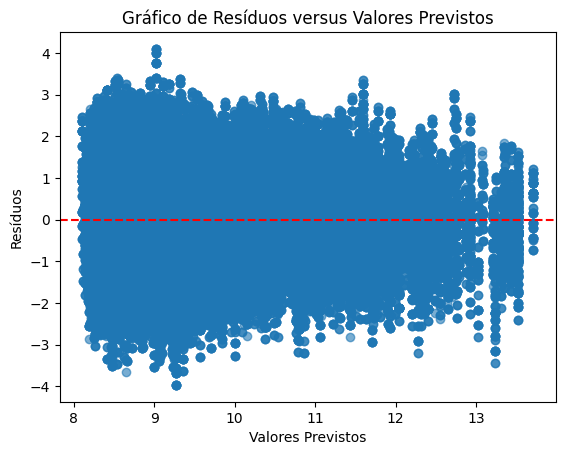

In [7]:
# Obtendo os valores previstos pelo modelo
preditos = res.predict()

plt.scatter(preditos, residuos, alpha=0.6)
plt.title('Gráfico de Resíduos versus Valores Previstos')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='--')  # Adiciona uma linha horizontal em y=0 para referência
plt.show()


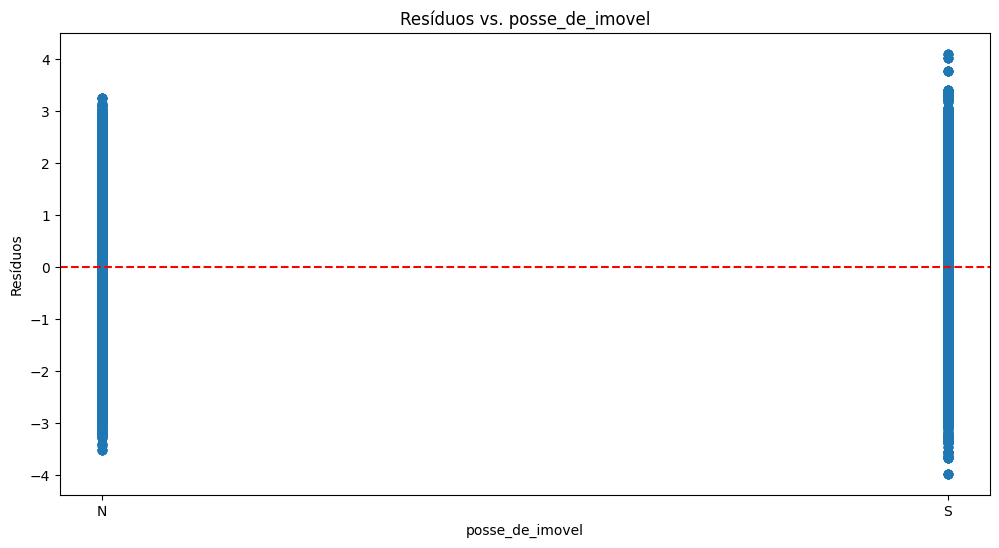

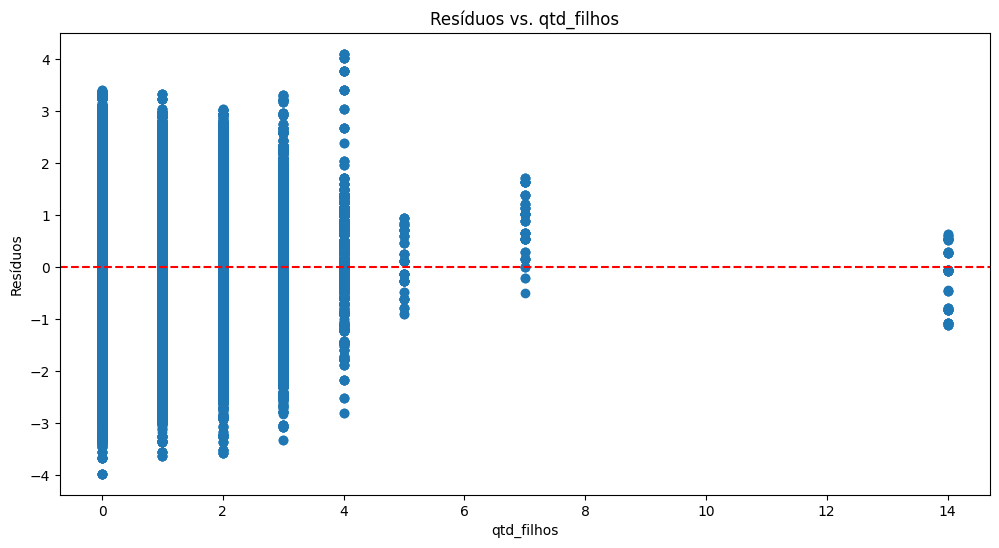

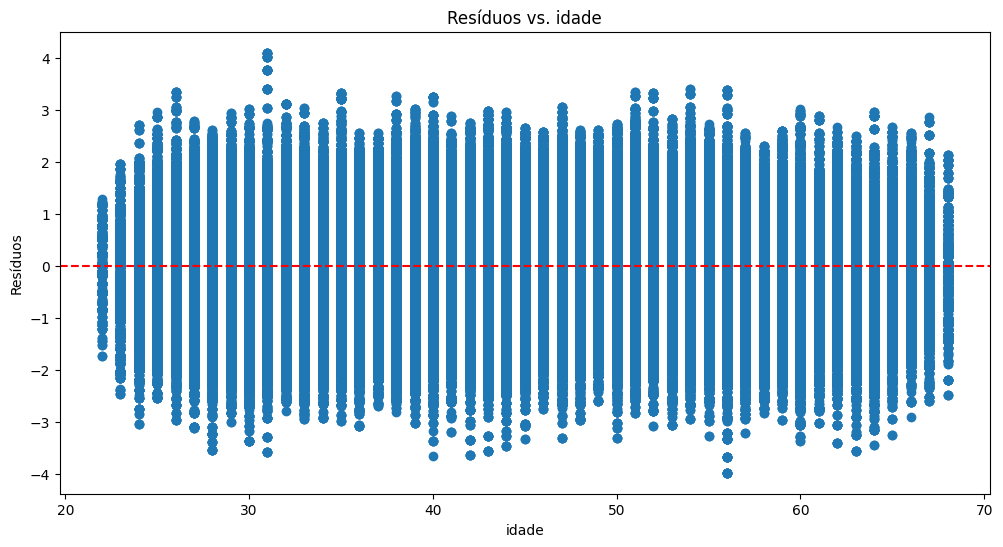

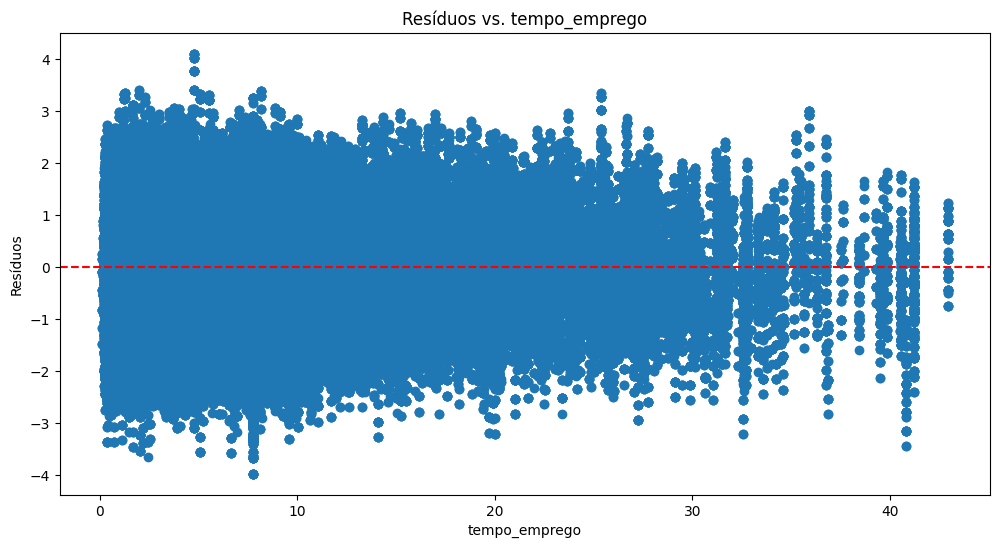

In [8]:
# Gráficos de dispersão dos resíduos em relação às variáveis independentes
variaveis_independentes = ['posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego']

for variavel in variaveis_independentes:
    plt.figure(figsize=(12, 6))
    plt.scatter(df_train[variavel], residuos)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Resíduos vs. {variavel}')
    plt.xlabel(variavel)
    plt.ylabel('Resíduos')
    plt.show()


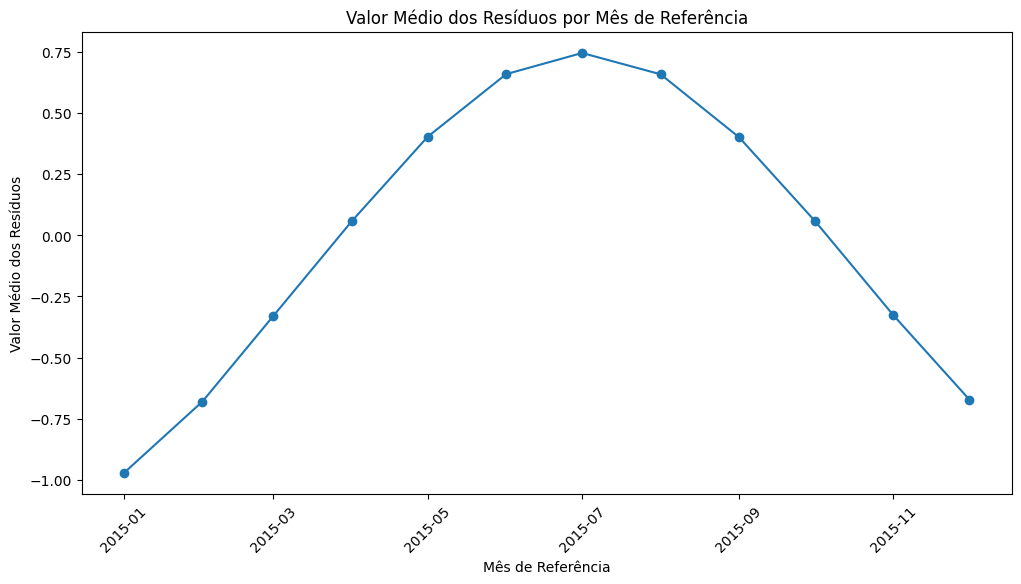

In [9]:
# Convertendo a coluna 'data_ref' para o formato de data
df_train['data_ref'] = pd.to_datetime(df_train['data_ref'])

# Calculando o valor médio dos resíduos para cada mês
residuos_medios_por_mes = df_train.groupby(df_train['data_ref'].dt.to_period("M"))['residuos'].mean()

# Convertendo os períodos de volta para datas
residuos_medios_por_mes.index = residuos_medios_por_mes.index.to_timestamp()

# Criando um gráfico de linha para visualizar a relação
plt.figure(figsize=(12, 6))
plt.plot(residuos_medios_por_mes.index, residuos_medios_por_mes.values, marker='o', linestyle='-')
plt.title('Valor Médio dos Resíduos por Mês de Referência')
plt.xlabel('Mês de Referência')
plt.ylabel('Valor Médio dos Resíduos')
plt.xticks(rotation=45)  # Rotacionar os rótulos no eixo x para melhor visualização
plt.show()

<span style="color:darkolivegreen;"> Os resíduos aparentam ter uma distribuição bem homogênea.</span>

<span style="color:darkolivegreen;"> 1. **Normalidade**: Os resíduos seguem uma distribuição normal, o que é bom para nossos estimadores.<br>
2. **Homocedasticidade**: O gráfico de resíduos versus valores previstos mostra que a variância dos resíduos é constante, o que é importante para a confiabilidade das previsões.<br>
3. **Independência**: A concentração dos resíduos em faixas de baixo valor para 'tempo_emprego' indica uma violação da suposição de independência.</span>

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

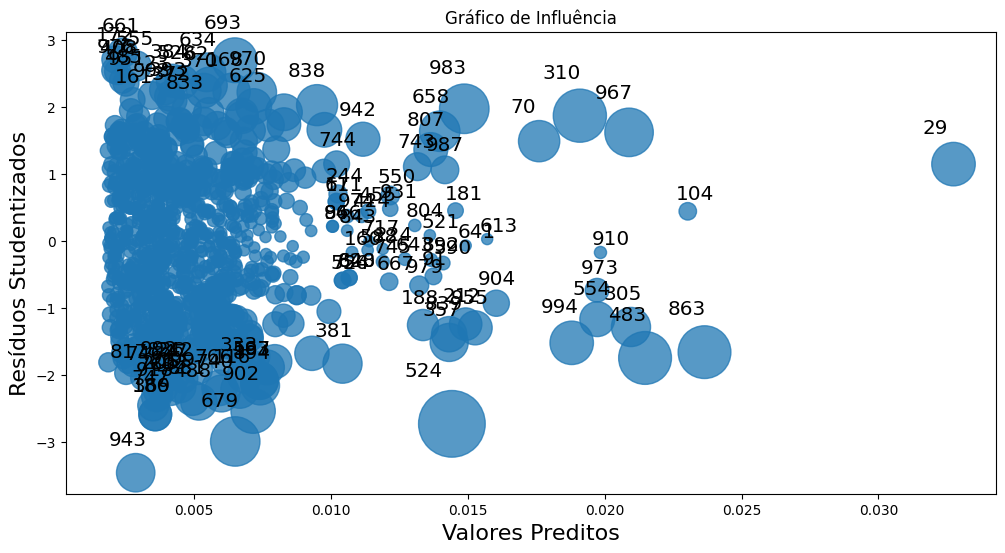

In [10]:
# Carregando uma amostra dos dados (as primeiras 1000 linhas)
df_sample = df.head(1000)

# Ajustando o modelo à amostra dos dados
model = smf.ols('log_renda ~ C(posse_de_imovel) + qtd_filhos + idade + tempo_emprego + 1', data=df_sample).fit()

# Calculando os studentized residuals
studentized_residuals = model.get_influence().resid_studentized_external

# Criando o gráfico de influência
fig, ax = plt.subplots(figsize=(12, 6))
influence_plot = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")

plt.title('Gráfico de Influência')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos Studentizados')
plt.show()

<span style="color:darkolivegreen;"> Com base na análise de outliers e pontos influentes, nota-se que alguns pontos podem estar exercendo uma influência negativa sobre o modelo.</span>

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [11]:
# Calculando a matriz de correlação de Spearman
var = ['qtd_filhos','idade','tempo_emprego','qt_pessoas_residencia']
df_train[var].corr(method='spearman')

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia
qtd_filhos,1.000000,-0.415384,-0.090583,0.828570
idade,-0.415384,1.000000,0.301418,-0.350081
tempo_emprego,-0.090583,0.301418,1.000000,-0.058691
qt_pessoas_residencia,0.828570,-0.350081,-0.058691,1.000000


In [12]:
# Selecionando as variáveis categóricas que precisam de variáveis dummy
variaveis = ['sexo','posse_de_veiculo','posse_de_imovel','qtd_filhos','tipo_renda','educacao','estado_civil',
            'tipo_residencia','idade','tempo_emprego','qt_pessoas_residencia']
# Criando as variáveis dummy
df_dum = pd.get_dummies(df[variaveis], drop_first=True)

In [13]:
# Calculando o fator VIF para cada variável dummy
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(df_dum, i) for i in range(df_dum.shape[1])]
vars_vif["Feature"] = df_dum.columns
vars_vif.round(2)

,VIF Factor,Feature
0,34.53,qtd_filhos
1,34.63,idade
2,3.02,tempo_emprego
3,241.30,qt_pessoas_residencia
4,1.82,sexo_M
5,1.97,posse_de_veiculo_S
6,3.24,posse_de_imovel_S
7,1.00,tipo_renda_Bolsista
8,1.48,tipo_renda_Empresário
9,2.20,tipo_renda_Pensionista


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [14]:
# Criando variáveis dummy para treinamento e teste
df_train_dum = pd.get_dummies(df_train[variaveis], drop_first=True)
df_test_dum = pd.get_dummies(df_test[variaveis], drop_first=True)

# Definindo as variáveis a serem descartadas com base na análise VIF
var_drop = ['qtd_filhos', 'idade', 'qt_pessoas_residencia']

# Criando DataFrames ajustados para treinamento e teste, removendo as variáveis descartadas
df_train_adj = df_train_dum.drop(var_drop, axis=1)
df_test_adj = df_test_dum.drop(var_drop, axis=1)

# Definindo a variável alvo (log_renda)
y_train = df_train['log_renda']
y_test = df_test['log_renda']

# Definindo as variáveis independentes (X) para treinamento e teste
x_train = df_train_adj
x_test = df_test_adj

In [29]:
# Criando e ajustando o modelo de regressão com as variáveis selecionadas
modelo_ajustado = sm.OLS(y_train, sm.add_constant(x_train)).fit()

# Realizando previsões com o modelo original (usando o conjunto de teste)
previsoes_original = modelo_ajustado.predict(sm.add_constant(df_test_adj))

# Realizando previsões com o modelo ajustado (usando o conjunto de teste)
previsoes_ajustado = modelo_ajustado.predict(sm.add_constant(df_test_adj))

# Avaliando as métricas de desempenho do modelo original
rmse_original = mean_squared_error(y_test, previsoes_original, squared=False)
r2_original = r2_score(y_test, previsoes_original)

# Avaliando as métricas de desempenho do modelo ajustado
rmse_ajustado = mean_squared_error(y_test, previsoes_ajustado, squared=False)
r2_ajustado = r2_score(y_test, previsoes_ajustado)

# Comparando as métricas de desempenho
print(f"RMSE do Modelo Original: {rmse_original:.2f}")
print(f"R^2 do Modelo Original: {r2_original:.2f}")
print(f"RMSE do Modelo Ajustado: {rmse_ajustado:.2f}")
print(f"R^2 do Modelo Ajustado: {r2_ajustado:.2f}")

RMSE do Modelo Original na Base de Teste: 1.40
R^2 do Modelo Original na Base de Teste: -0.64
RMSE do Modelo Ajustado na Base de Teste: 1.40
R^2 do Modelo Ajustado na Base de Teste: -0.64


<span style="color:darkolivegreen;"> Os resultados das métricas do modelo original e ajustado são os mesmos! Isso sugere que o ajuste do modelo não teve um impacto significativo no desempenho do modelo em relação ao modelo original. Um valor negativo para R^2 indica que o modelo não está se ajustando bem aos dados e não é capaz de fazer boas previsões.</span>